https://github.com/lysecret2/ES-RNN-Pytorch

https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/4_ES_RNN.ipynb

In [1]:
#import packages
import random
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import Dataset,sampler,DataLoader
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
plt.style.use('seaborn-colorblind')
%matplotlib inline
%load_ext autotime

class sequence_labeling_dataset(Dataset):
    
    def __init__(self, input, max_size=100, sequence_labeling=True, seasonality=12, out_preds=12):     
        self.data = input
        self.max_size = max_size
        self.sequence_labeling = sequence_labeling
        self.seasonality = seasonality
        self.out_preds = out_preds
        
    def __len__(self):
        return int(10000)
    
    def __getitem__(self, index):
        data_i = self.data
        
        #we randomly shift the inputs to create more data
        if len(data_i) > self.max_size:
            max_rand_int = len(data_i) - self.max_size
            #take a random start integer
            start_int = random.randint(0, max_rand_int)
            data_i = data_i[start_int:(start_int + self.max_size)]
        else:
            start_int=0

        inp = np.array(data_i[:-self.out_preds])        
        
        if self.sequence_labeling == True:
            #in case of sequence labeling, we shift the input by the range to output
            out = np.array(data_i[self.out_preds:])
        else:
            #in case of sequnec classification we return only the last n elements we
            #need in the forecast
            out = np.array(data_i[-self.out_preds:])
            
        #This defines, how much we have to shift the season 
        shift_steps = start_int%self.seasonality
        
        return inp, out,shift_steps
    
class holt_winters_no_trend(torch.nn.Module):
    
    def __init__(self, init_a=0.1, init_g=0.1, slen=12):
        super(holt_winters_no_trend, self).__init__()
        #Smoothing parameters
        self.alpha = torch.nn.Parameter(torch.tensor(init_a))
        self.gamma = torch.nn.Parameter(torch.tensor(init_g))
        #init parameters
        self.init_season = torch.nn.Parameter(torch.tensor(np.random.random(size=slen)))
        #season legnth used to pick appropriate past season step 
        self.slen = slen
        #Sigmoid used to norm the params to be betweeen 0 and 1 if needed 
        self.sig = torch.nn.Sigmoid()
        
    def forward(self, series, series_shifts, n_preds=12, rv=False):
        #Get Batch size
        batch_size = series.shape[0]
        #Get the initial seasonality parameter
        init_season_batch = self.init_season.repeat(batch_size).view(batch_size, -1)
        #We use roll to Allow for our random input shifts.
        seasonals = torch.stack([torch.roll(j, int(rol)) for j, rol in zip(init_season_batch, series_shifts)]).float()
        #It has to be a list such that we dont need inplace tensor changes. 
        seasonals = list(torch.split(seasonals, 1, dim=1))
        seasonals = [x.squeeze() for x in seasonals]
        #Now We loop over the input in each forward step
        result = []
        
        #rv can be used for decomposing a series./normalizing in case of ES-RNN
        if rv == True:
            value_list = []
            season_list = []

        for i in range(series.shape[1] + n_preds):
            #0th step we init the parameter 
            if i == 0: 
                smooth = series[:,0]
                value_list.append(smooth)
                season_list.append(seasonals[i%self.slen])                
                result.append(series[:,0])
                continue

            #smoothing
            #its smaller here, so smoothing is only for one less than the input? 
            if i < series.shape[1]:
                val = series[:,i]
                last_smooth, smooth = smooth, self.sig(self.alpha) * (val - seasonals[i%self.slen]) + (1 - self.sig(self.alpha)) * (smooth)
                seasonals[i%self.slen] = self.sig(self.gamma) * (val - smooth) + (1 - self.sig(self.gamma)) * seasonals[i%self.slen]
                #we store values, used for normaizing in ES RNN 
                if rv == True:
                    value_list.append(smooth)
                    season_list.append(seasonals[i%self.slen])
                result.append(smooth + seasonals[i%self.slen])
            
            #forecasting would jsut select last smoothed value and the appropriate seasonal, we will do this seperately 
            #in the ES RNN implementation
            else:
                m = i - series.shape[1] + 1
                result.append((smooth) + seasonals[i%self.slen])
                if rv == True:
                    value_list.append(smooth)
                    season_list.append(seasonals[i%self.slen])
                
        #If we want to return the actual, smoothed values or only the forecast
        if rv == False:
            return torch.stack(result, dim=1)[:, -n_preds:]
        else:
            return torch.stack(result, dim=1), torch.stack(value_list, dim=1), torch.stack(season_list, dim=1)        
            
class es_rnn(torch.nn.Module):
    
    def __init__(self, hidden_size=16, slen=12, pred_len=12):
        super(es_rnn, self).__init__()
        self.hw = holt_winters_no_trend(init_a=0.1, init_g=0.1)
        self.RNN = torch.nn.GRU(hidden_size=hidden_size, input_size=1, batch_first=True)
        self.lin = torch.nn.Linear(hidden_size, pred_len)
        self.pred_len = pred_len
        self.slen = slen
        
    def forward(self, series, shifts):
        #Get Batch size
        batch_size = series.shape[0]
        result, smoothed_value, smoothed_season = self.hw(series, shifts, rv=True, n_preds=0)
        
        de_season = series - smoothed_season
        de_level = de_season - smoothed_value
        noise = torch.randn(de_level.shape[0], de_level.shape[1])
        noisy = de_level #+noise
        noisy = noisy.unsqueeze(2)
        
        #take the last element in the sequence t agg (can also use attn)
        feature = self.RNN(noisy)[1].squeeze() #[-1,:,:]
        pred = self.lin(feature)
        
        #äthe season forecast entail just taking the correct smooothed values 
        season_forecast = []
        for i in range(self.pred_len):
            season_forecast.append(smoothed_season[:, i%self.slen])
        season_forecast = torch.stack(season_forecast, dim=1)
        
        #in the end we multiply it all together and we are done!
        #here additive seems to work a bit better, need to make that an if/else of the model
        return smoothed_value[:,-1].unsqueeze(1) + season_forecast + pred
    

In [2]:
#Target 
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

train_sample = series[:-12]
test_sample = series

sequence_labeling_tr = sequence_labeling_dataset(train_sample, 1000, False)
sequence_labeling_ts = sequence_labeling_dataset(test_sample, 1000, False)

train_dataloader = DataLoader(dataset = sequence_labeling_tr,
                              batch_size = 512,
                              shuffle = False)
test_dataloader = DataLoader(dataset = sequence_labeling_ts,
                             batch_size = 512,
                             shuffle = False)


time: 3.39 ms


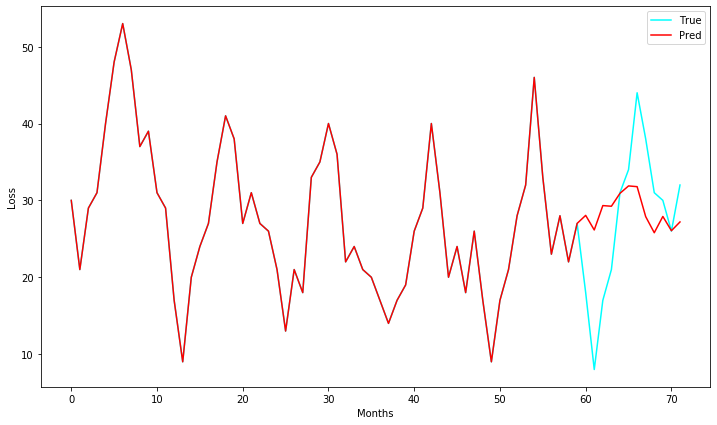

tensor(8.9482, grad_fn=<PowBackward0>)
tensor(9.5917)
time: 408 ms


In [3]:
#making ES-RNN model
hw = es_rnn()
opt = torch.optim.Adam(hw.parameters(), lr = 0.01) #,weight_decay=0.0001

#Initial Prediction
overall_loss = []
test_batch = next(iter(test_dataloader))
inp = test_batch[0].float() #.unsqueeze(2)
out = test_batch[1].float() #.unsqueeze(2).float()
shifts = test_batch[2].numpy()
pred = hw(inp, shifts)

rcParams['figure.figsize'] = 12, 7
plt.plot(torch.cat([inp[0], out[0,:]]).detach().numpy(), "cyan")
plt.plot(torch.cat([inp[0], pred[0,:]]).detach().numpy(), "r")
plt.legend(['True', 'Pred'])
plt.xlabel('Months')
plt.ylabel('Loss')
plt.show()

#Initial Loss RMSE 
print((torch.mean((pred - out) ** 2)) ** (1/2))
#Baseline Loss Predicting last value at each step
print((torch.mean((inp[0][-1] - out) ** 2)) ** (1/2))

  5%|▌         | 1/20 [00:03<01:02,  3.31s/it]

6.8896894
7.259225


 10%|█         | 2/20 [00:06<00:58,  3.27s/it]

4.1503057
4.495908


 15%|█▌        | 3/20 [00:09<00:54,  3.23s/it]

2.865744
1.729317


 20%|██        | 4/20 [00:12<00:51,  3.20s/it]

2.89682
0.26327974


 25%|██▌       | 5/20 [00:15<00:47,  3.18s/it]

2.8884811
0.07372396


 30%|███       | 6/20 [00:19<00:44,  3.16s/it]

2.8860033
0.025782015


 35%|███▌      | 7/20 [00:22<00:41,  3.16s/it]

2.9033055
0.017783402


 40%|████      | 8/20 [00:25<00:37,  3.15s/it]

2.8910449
0.0120824


 45%|████▌     | 9/20 [00:28<00:34,  3.15s/it]

2.8906248
0.010929021


 50%|█████     | 10/20 [00:31<00:31,  3.20s/it]

2.8954546
0.009422218


 55%|█████▌    | 11/20 [00:34<00:28,  3.21s/it]

2.8914719
0.010016938


 60%|██████    | 12/20 [00:38<00:27,  3.44s/it]

2.8891268
0.012914737


 65%|██████▌   | 13/20 [00:43<00:25,  3.63s/it]

2.893627
0.011112379


 70%|███████   | 14/20 [00:46<00:21,  3.57s/it]

2.8940914
0.0130868275


 75%|███████▌  | 15/20 [00:49<00:17,  3.43s/it]

2.8921618
0.010628145


 80%|████████  | 16/20 [00:52<00:13,  3.35s/it]

2.8964164
0.0110556


 85%|████████▌ | 17/20 [00:56<00:10,  3.56s/it]

2.8992603
0.013691892


 90%|█████████ | 18/20 [01:00<00:07,  3.52s/it]

2.8967607
0.013844508


 95%|█████████▌| 19/20 [01:03<00:03,  3.46s/it]

2.89759
0.013206013


100%|██████████| 20/20 [01:06<00:00,  3.37s/it]

2.8967743
0.0127649335


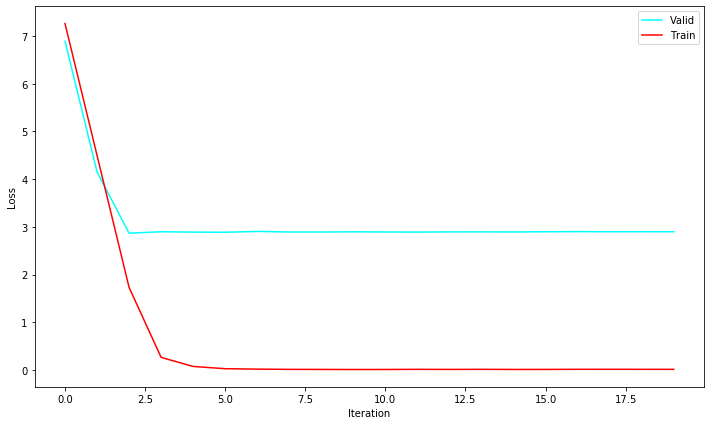

time: 1min 6s


In [4]:
overall_loss_train = []
overall_loss = []

for j in tqdm(range(20)):
    loss_list_b = []
    train_loss_list_b = []
    #here we use batches of past, and to be forecasted value
    #batches are determined by a random start integer
    for train_batch in iter(train_dataloader):
        opt.zero_grad()
        inp = train_batch[0].float()
        out = train_batch[1].float()
        shifts = train_batch[2].numpy()
        #it returns the whole sequence atm 
        pred = hw(inp, shifts)
        loss = (torch.mean((pred - out) ** 2)) ** (1/2)
        train_loss_list_b.append(loss.detach().cpu().numpy())
        loss.backward()
        opt.step()

    #here we use all the available values to forecast the future ones and eval on it
    for test_batch in iter(test_dataloader):
        inp = test_batch[0].float()
        out = test_batch[1].float()
        shifts = test_batch[2].numpy()
        pred = hw(inp,shifts)
        loss = (torch.mean((pred-out) ** 2)) ** (1/2)
        loss_list_b.append(loss.detach().cpu().numpy())
    
    print(np.mean(loss_list_b))
    print(np.mean(train_loss_list_b))
    overall_loss.append(np.mean(loss_list_b))
    overall_loss_train.append(np.mean(train_loss_list_b))
    
#Plot of Train and Validatiaon Loss, we nicely converge
rcParams['figure.figsize'] = 12, 7
plt.plot(overall_loss,"cyan")
plt.plot(overall_loss_train,"r")
plt.legend(['Valid', 'Train'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

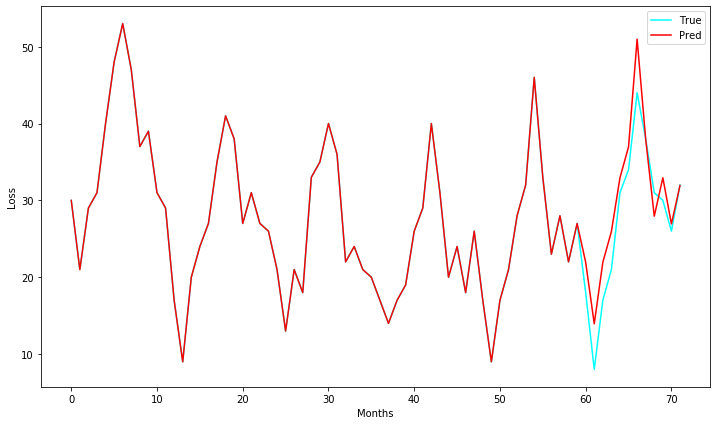

time: 363 ms


In [5]:
#Forecasting on the Validation set
test_batch = next(iter(test_dataloader))
inp = test_batch[0].float() #.unsqueeze(2)
out = test_batch[1].float() #.unsqueeze(2).float()
shifts = test_batch[2].numpy()
pred = hw(torch.cat([inp, out], dim=1), shifts)

rcParams['figure.figsize'] = 12, 7
plt.plot(torch.cat([inp[0], out[0,:]]).detach().numpy(), "cyan")
plt.plot(torch.cat([inp[0], pred[0,:]]).detach().numpy(), "r")
plt.legend(['True', 'Pred'])
plt.xlabel('Months')
plt.ylabel('Loss')
plt.show()

In [6]:
param_list = []
for params in hw.parameters():
    param_list.append(params)
param_list = torch.sigmoid(params[0:2]).detach().numpy()

print(param_list)

[0.39666688 0.28511664]
time: 2.02 ms
